# Исследовательский анализ данных

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## План работы

<h3>1. Предобработка данных. </h3>
<div>Подготовить данные к последующему анализу: проверить пропущенные значения, при необходимости изменить тип данных и заполнить пропуски. Выявить целевой признак.</div>
<h3>2.Анализ данных.</h3>
<div> Сравнить частоту подключений и отказов от обслуживания для всех всех типах услуг. Выявить признаки, влияющие на целевой. </div>
<h3>3. Построить модель.</h3>
<div> Разделить данные на обучающую, валидационную и тестовую выборки. Обучить разные модели с различными гиперпараметрами.</div>
<h3>4. Проверка качества модели.</h3>
<div>Выберать лучшую модель и проверьте её на тестовой выборке. </div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns

In [2]:
contract_data=pd.read_csv('/datasets/final_provider/contract.csv').reset_index(drop=True)
personal_data=pd.read_csv('/datasets/final_provider/personal.csv')
internet_data=pd.read_csv('/datasets/final_provider/internet.csv')
phone_data=pd.read_csv('/datasets/final_provider/phone.csv')

### 1. Предобработка данных

#### 1.1 Обработка информацию о договорах

In [3]:
contract_data.head(70)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
65,5122-CYFXA,2019-11-01,No,Month-to-month,Yes,Electronic check,75.30,244.1
66,8627-ZYGSZ,2016-03-01,No,One year,Yes,Electronic check,78.90,3650.35
67,3410-YOQBQ,2017-07-01,No,Two year,No,Mailed check,79.20,2497.2
68,3170-NMYVV,2015-12-01,No,Two year,No,Bank transfer (automatic),20.15,930.9


In [4]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропущенных значений нет, необходимо изменить тип данных в столбцах:BeginDate,EndDate и TotalCharges. Также создадим дополнительный столбец с данными об отказах от услуги. В таблице нет данных о типе услуг.

In [3]:
# столбец, указывающий отказ от услуг
contract_data['number_rescind'] = (
    contract_data['EndDate']
    .where(contract_data['EndDate']!= 'No', '0')
    .where(contract_data['EndDate']== 'No', '1')
    .astype('int')
)

In [4]:
# изменение типа данных на datetime в столбце BeginDate
contract_data['BeginDate'] = contract_data['BeginDate'].astype('datetime64')

In [5]:
# изменение типа данных на datetime в столбце EndDate
contract_data['EndDate']=contract_data['EndDate'].replace('No','2020-02-01 00:00:00')
contract_data['EndDate'] = contract_data['EndDate'].astype('datetime64')

In [6]:
# изменение типа данных на float в столбце TotalCharges
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'],errors='coerce')


In [7]:
# замена значений Yes и No на 1 и 0:
for i in contract_data:
    contract_data = (
    contract_data
    .where(contract_data != 'No', '0')
    .where(contract_data != 'Yes', '1')
)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [8]:
contract_data=contract_data.dropna()

#### 1.2 Обработка информации о персональных данных

In [11]:
personal_data

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [12]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Таблица содержит данные о поле клиента, является ли он пенсионером, есть ли дети, состоит ли в браке. Для удобства и дальнейшего обучения необходимо заменить значения 'Yes' и 'No' на '1' и '0' соответственно. Также добавим столбец с информацией об отказе от услуги.

In [9]:
# замена значений Yes и No на 1 и 0:
for i in personal_data:
    personal_data = (
    personal_data
    .where(personal_data != 'No', '0')
    .where(personal_data != 'Yes', '1')
)

In [10]:
#добавление столбца number_rescind:
personal_data=personal_data.join(pd.DataFrame(contract_data[['customerID','number_rescind']]).set_index('customerID'), on='customerID')

#### 1.3 Обработка информации об интернет-услугах

In [15]:
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Таблица содержит информацию о подключениях: антивируса (DeviceProtection), блокировщика небезопасных сайтов (OnlineSecurity), техподдержки (TechSupport), хранилища для резервного копирования данных (OnlineBackup), cтриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies). Пропущенных значений нет, тип данных менять не нужно. Для удобства и дальнейшего обучения необходимо заменить значения 'Yes' и 'No' на '1' и '0' соответственно. Также добавим столбец с информацией об отказе от услуги.

In [11]:
# замена значений Yes и No на 1 и 0:
for i in internet_data:
    internet_data = (
    internet_data
    .where(internet_data != 'No', '0')
    .where(internet_data != 'Yes', '1')
)

In [12]:
columns=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

In [13]:
for i in columns:
    internet_data[i]=internet_data[i].astype('int')

In [14]:
#добавление столбца number_rescind:
internet_data=internet_data.join(pd.DataFrame(contract_data[['customerID','number_rescind']]).set_index('customerID'), on='customerID')

#### 1.4 Обработка информации об услугах телефонии

In [21]:
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [22]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Пропущенных значений нет. Для удобства и дальнейшего обучения необходимо заменить значения 'Yes' и 'No' на '1' и '0' соответственно. Также добавим столбец с информацией об отказе от услуги.

In [15]:
# замена значений Yes и No на 1 и 0:
phone_data['MultipleLines'] = (
    phone_data['MultipleLines']
    .where(phone_data['MultipleLines']!= 'No', '0')
    .where(phone_data['MultipleLines']!= 'Yes', '1')
)

In [16]:
#добавление столбца number_rescind:
phone_data=phone_data.join(pd.DataFrame(contract_data[['customerID','number_rescind']]).set_index('customerID'), on='customerID')

# 2. Исследовательский анализ данных

## 2.1 Изучим информацию о договорах

In [17]:
 contract_data['full_month']=(contract_data['EndDate']-contract_data['BeginDate'])

In [18]:
contract_data['full_month']= contract_data['full_month']/ np.timedelta64(1, 'D')
contract_data['full_month']=contract_data['full_month']/30.0
contract_data['full_month']=contract_data['full_month'].round(1)

Text(0.5, 1.0, 'Средняя продолжительность действия договора')

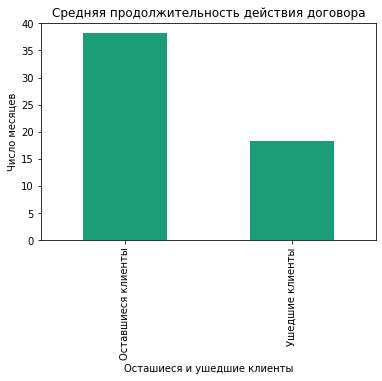

In [27]:
contract_data.pivot_table(index='number_rescind', values='full_month', aggfunc='mean').plot(kind='bar',color=plt.cm.Dark2(np.arange(len(contract_data))),legend=False)
plt.xticks([0,1],['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.xlabel('Осташиеся и ушедшие клиенты')
plt.ylabel('Число месяцев')
plt.title('Средняя продолжительность действия договора')

Чаще всего уходят клиенты, которые пользуются услугами компании меньше 20 месяцев.

In [28]:
contract_data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,number_rescind,full_month
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,1.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,34.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,45.7
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.50,0,24.3
7039,2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90,0,73.0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,0,11.2
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,1,4.1


### 2.1.1 Анализ сезонности ухода клиентов

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
# таблица с информацией об уходе клиентов по датам
rescind_data=contract_data.pivot_table(index='EndDate', values='number_rescind', aggfunc='sum').query('EndDate != "1970-01-01"')

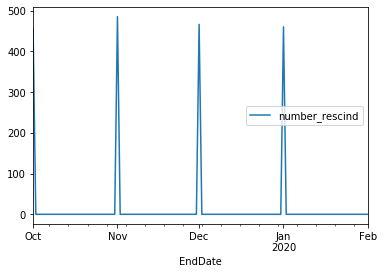

In [31]:
# выполним ресэмплирование данных по дням
rescind_data=rescind_data.resample('1D').sum()
rescind_data.plot()

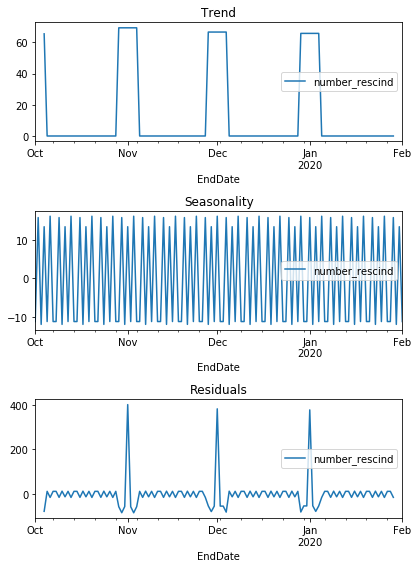

In [32]:
# посмотрим тренд и сезонность в течение всего периода наблюдений
decomposed = seasonal_decompose(rescind_data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренда нет. Договора обнуляются в первом числе месяца.

### 2.1.2 Изучим частоту отказов в зависимости от особенностей договора

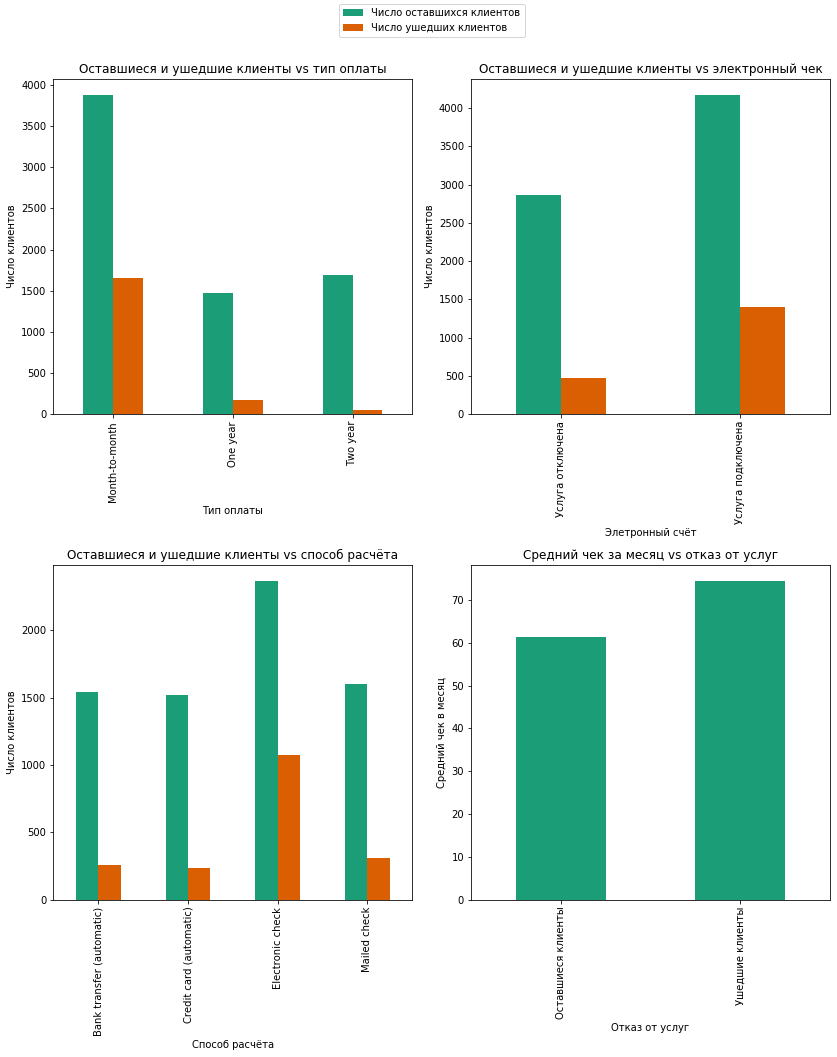

In [33]:

plt.figure(figsize=(12, 14))
plt.subplot(2, 2, 1)
contract_data.pivot_table(index='Type', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar',ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Тип оплаты')
plt.title('Оставшиеся и ушедшие клиенты vs тип оплаты')

plt.subplot(2, 2, 2)
contract_data.pivot_table(index='PaperlessBilling', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Элетронный счёт')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты vs электронный чек')

plt.subplot(2, 2, 3)
contract_data.pivot_table(index='PaymentMethod', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Способ расчёта')
plt.title('Оставшиеся и ушедшие клиенты vs способ расчёта')

plt.subplot(2, 2, 4)
contract_data.pivot_table(index='number_rescind', values='MonthlyCharges', aggfunc='mean').plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Средний чек в месяц')
plt.xlabel('Отказ от услуг')
plt.xticks([0,1],['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Средний чек за месяц vs отказ от услуг')



plt.figlegend(['Число оставшихся клиентов','Число ушедших клиентов'], loc = 'upper center', bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()

<div>1. Клиенты, которые платят каждый месяц, чаще всего отказываются от услуг.</div>
<div>2. Большая часть клиетов запрашивает электронный счёт. При этом, именно такие клиенты чаще отказываются от обслуживания.</div>
<div>3. Большая часть клиентов оплачивает счёт через eCheck, и они чаще отказываются от обслуживания. Клиентов, использующих другие способы оплаты меньше, но они значительно реже отказываются от обслуживания.</div>
<div>4. Чаще всего отказываются от обслуживания клиенты, у которых высокий ежемесячный счёт. </div>

## 2.2 Изучим информацию о персональных данныx

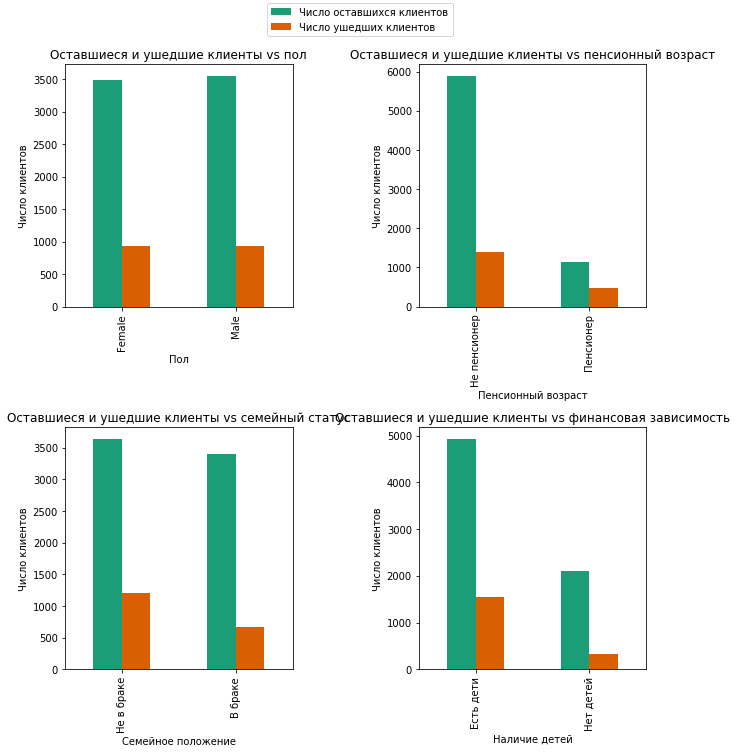

In [34]:

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
personal_data.pivot_table(index='gender', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar',ax=plt.gca(),legend=False,
                                                                                                color=plt.cm.Dark2(np.arange(len(personal_data))))
plt.ylabel('Число клиентов')
plt.xlabel('Пол')
plt.title('Оставшиеся и ушедшие клиенты vs пол')

plt.subplot(2, 2, 2)
personal_data.pivot_table(index='SeniorCitizen', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),                                                                                                     color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Пенсионный возраст')
plt.xticks([0,1],['Не пенсионер', 'Пенсионер'])
plt.title('Оставшиеся и ушедшие клиенты vs пенсионный возраст')

plt.subplot(2, 2, 3)
personal_data.pivot_table(index='Partner', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),
                                                                                                  color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Семейное положение')
plt.xticks([0,1],['Не в браке', 'В браке'])
plt.title('Оставшиеся и ушедшие клиенты vs семейный статус')

plt.subplot(2, 2, 4)
personal_data.pivot_table(index='Dependents', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),                                                                                                    color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Наличие детей')
plt.xticks([0,1],['Есть дети', 'Нет детей'])
plt.title('Оставшиеся и ушедшие клиенты vs финансовая зависимость')

plt.tight_layout()
plt.figlegend(['Число оставшихся клиентов','Число ушедших клиентов'], loc = 'upper center', bbox_to_anchor=(0.5, 1.05))

Женщины и мужчины в равной степени отказываются от услуг. Пенсионеры, неженатые и лица с финансовой независимостью ,чаще расторгают договор.

## 2.3 Изучим информацию об интернет услугах

### 2.3.1 Сравним популярность дополнительных интернет услуг

Text(0.5, 1.0, 'Частота подлючения дополнительных услуг среди оставшихся и ушедших клиентов')

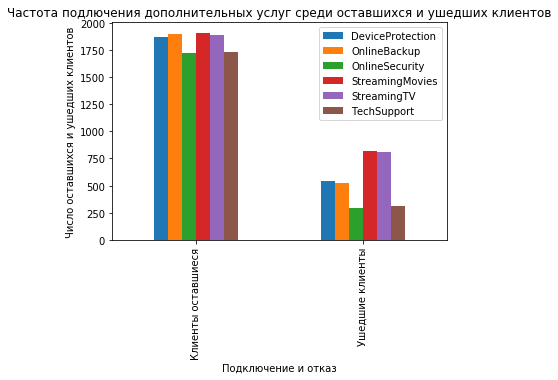

In [35]:
# график числа подключений дополнительных интернет-услуг и отказа от облуживания 
internet_data.pivot_table(index='number_rescind',values=['InternetService','OnlineSecurity','OnlineBackup',
                                                         'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'], 
                                                      aggfunc='sum').plot(kind='bar')
plt.xlabel('Подключение и отказ')
plt.ylabel('Число оставшихся и ушедших клиентов')
plt.xticks([0,1],['Клиенты оставшиеся', 'Ушедшие клиенты'])
plt.title('Частота подлючения дополнительных услуг среди оставшихся и ушедших клиентов')

Клиенты, которые не отказались от обслуживания немного чаще подлючают каталог фильмов, стриминговое телевидение, резервное копирование данных и антивирус. Реже подключают услуги техподдержки и блокировку небезопасных сайтов. Но разница в числе подлючений этих услуг не такая значительная, как в группе клиентов, отказавшихся от обслуживания. Чаще всего от обслуживания отказываются клиенты, подключившие каталог фильмов и стримминговое телевидение. В 1.3 раза реже отказываются клиенты, подключившие антивирус и резервное копирвание. И в 3 раза реже отказываются клиенты, подключившие техподдержку и блокировку небезопасных сайтов.

### 2.3.2 Сравнение популярности услуг для разных типов подключения интернета

Text(0.5, 1.0, 'Подключение дополнительных услуг для различных типов подключения интернета')

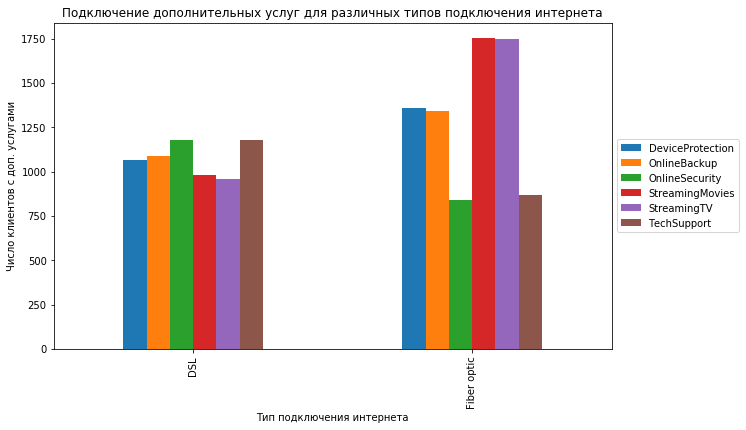

In [36]:

internet_service=internet_data.pivot_table(index='InternetService',values=['OnlineSecurity','OnlineBackup',
                                                         'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'],
                           aggfunc='sum')
plt.figure(figsize=(10, 6))           
internet_service.plot(kind='bar', legend=False,ax=plt.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Тип подключения интернета')
plt.ylabel('Число клиентов с доп. услугами')
plt.title('Подключение дополнительных услуг для различных типов подключения интернета')

У клиентов, подключенных через телефонную линию, разница в частоте использования различных дополнительных услуг невелика. Немного чаще подключают блокировку небезопасных сайтов и техническую поддержку, реже всего стримминговое телевидение и каталог фильмов. У клиентов, подлюченных через оптоволоконный кабель наблюдается большой разброс в частоте использования дополнительных услуг. Такие клиенты наоборот, чаще подключают стримминговое телевидение и каталог фильмов и реже всего блокировку небезопасных сайтов и техническую поддержку.

### 2.3.3 Изучим частоту отказов при использованнии различных доп. услуг

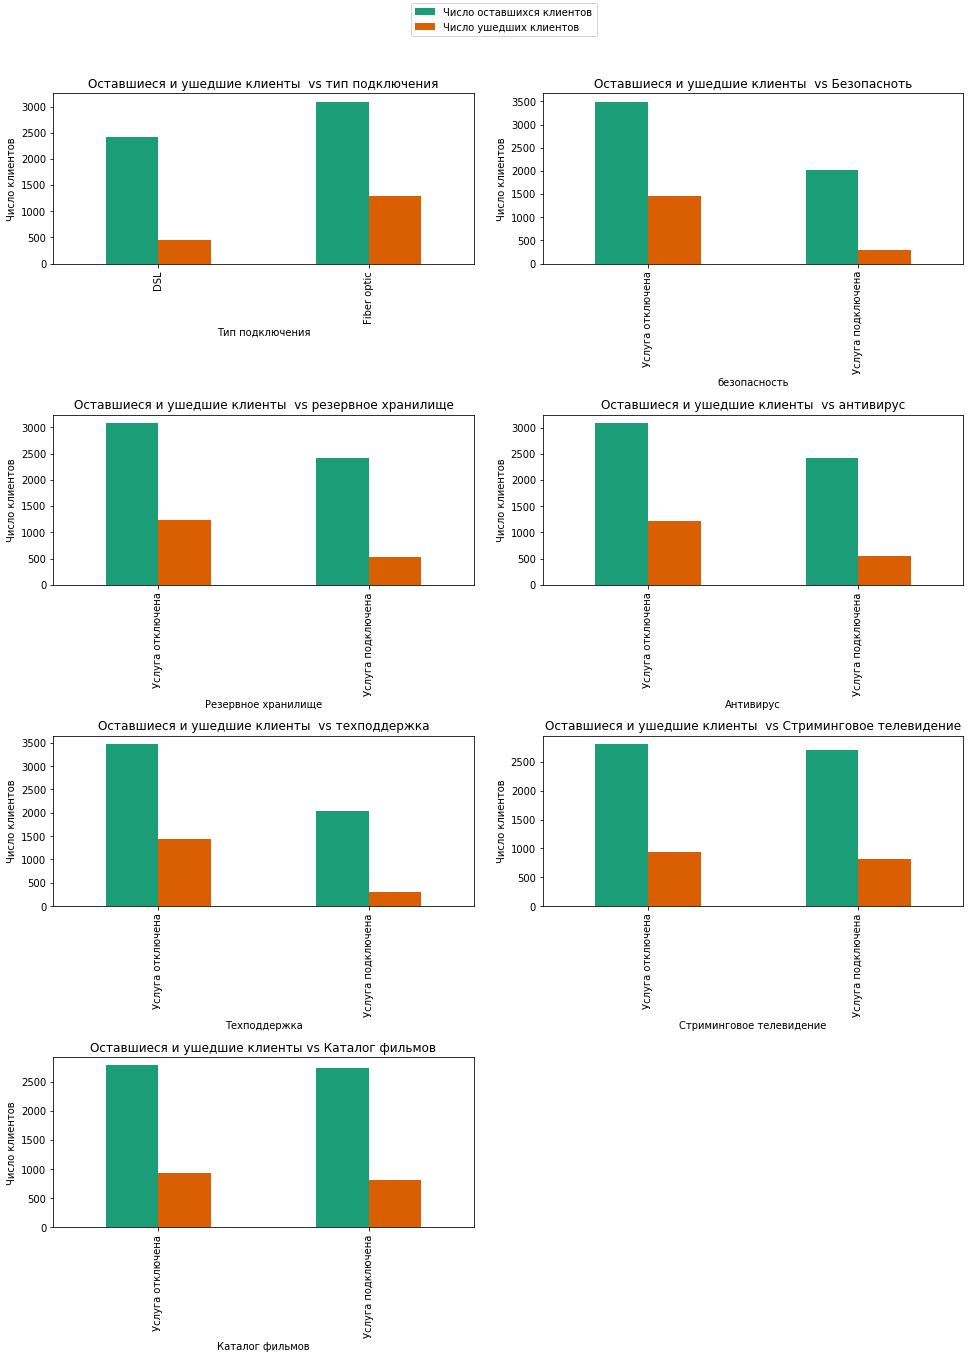

In [37]:

plt.figure(figsize=(14, 18))

plt.subplot(4, 2, 1)
internet_data_2=internet_data.pivot_table(index='InternetService', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar',ax=plt.gca(),
                                                                                                          color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Тип подключения')
plt.title('Оставшиеся и ушедшие клиенты  vs тип подключения')

plt.subplot(4, 2, 2)
internet_data.pivot_table(index='OnlineSecurity', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('безопасность')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты  vs Безопасноть')

plt.subplot(4, 2, 3)
internet_data.pivot_table(index='OnlineBackup', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Резервное хранилище')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты  vs резервное хранилище')

plt.subplot(4, 2, 4)
internet_data.pivot_table(index='DeviceProtection', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Антивирус')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты  vs антивирус')

plt.subplot(4, 2, 5)
internet_data.pivot_table(index='TechSupport', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Техподдержка')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты  vs техподдержка')

plt.subplot(4, 2, 6)
internet_data.pivot_table(index='StreamingTV', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Стриминговое телевидение')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты  vs Стриминговое телевидение')

plt.subplot(4, 2, 7)
internet_data.pivot_table(index='StreamingMovies', values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', ax=plt.gca(),color=plt.cm.Dark2(np.arange(len(personal_data))),legend=False)
plt.ylabel('Число клиентов')
plt.xlabel('Каталог фильмов')
plt.xticks([0,1],['Услуга отключена', 'Услуга подключена'])
plt.title('Оставшиеся и ушедшие клиенты vs Каталог фильмов')
plt.figlegend(['Число оставшихся клиентов','Число ушедших клиентов'], loc = 'upper center', bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()

Клиенты, подключенные через оптоволоконный кабель чаще отказываются от услуг. Клиенты, у которых подлючены такие услуги как: безопасность, техподдержка, стриминговое телевидение и резервное хранилище  реже отказываются от подключения. При этом подключение стримингового телевидения и каталога фильмов слабо влияет на решение об отключении.

## 2.4 Изучим  информацию об услугах телефонии

Text(0.5, 1.0, 'Число отказов vs мультителефония')

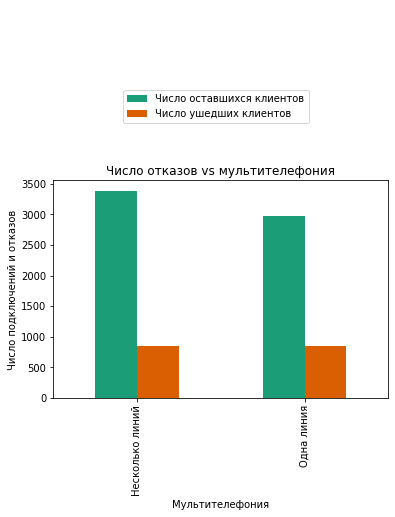

In [38]:
phone_data.pivot_table(index='MultipleLines',values='number_rescind', aggfunc=['count','sum']).plot(kind='bar', color=plt.cm.Dark2(np.arange(len(personal_data))), legend=False)
plt.ylabel('Число подключений и отказов')
plt.xlabel('Мультителефония')
plt.xticks([0,1],['Несколько линий', 'Одна линия'])
plt.figlegend(['Число оставшихся клиентов','Число ушедших клиентов'], loc = 'upper center', bbox_to_anchor=(0.5, 1.5))
plt.title('Число отказов vs мультителефония')

Клиенты, подключившие одну телефонную линию немного чаще отказываются от услуг.

## Выводы

1. Максимальная средняя продолжительность использования услуг компании среди ушедших клиентов- 20 месяцев. Средний ежемесячный чек ушедших клиентов больше, чем у оставшихся, возможно поэтому такие клиенты чаще отказываются от услуг.
2. Хотя клиентов пенсионного возраста меньше, чем до пенсионного, они в 2 раза чаще отказываются от услуг. Также поступают клиенты не состоящие в отношениях и самостоятельно распоряжающиеся финансами. Таким клиентам можно предлагать скидку.
3. Клиенты чаще подключают телевидение и каталог фильмов, но такие клиенты чаще отказываются от обслуживания. При этом другие дополнительные услуги подключаются реже, но и клиенты их использующие реже расторгают договор.
4. Клиенты использующие одну телефонную линию также чаще отказываются от обслуживания, чем клиенты мультителефонии.
5. Непонятно, почему клиенты чаще использующие популярные услуги чаще уходят.


# 3 Обучение модели

## 3.1 Подготовка итоговой таблицы признаков.

Соединим 4 исходные таблицы по стоблцу "customerID". Удалим столбцы:'customerID','BeginDate','EndDate', так как ID клиентов не влияет на целевой признак, а в датах интересна продолжительность использования ислуг, которая записана в столбце 'full_month'.

In [19]:
# создание итоговой таблицы
all_data = pd.merge(contract_data,personal_data.drop('number_rescind',axis=1), on="customerID")
all_data=all_data.join(internet_data.drop('number_rescind',axis=1).set_index('customerID'), on='customerID')
all_data=all_data.join(phone_data.drop('number_rescind',axis=1).set_index('customerID'), on='customerID')

In [20]:
# удаление неважных признаков
all_data=all_data.drop(['customerID','BeginDate','EndDate'], axis=1)

In [21]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
number_rescind      7032 non-null int64
full_month          7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null float64
OnlineBackup        5512 non-null float64
DeviceProtection    5512 non-null float64
TechSupport         5512 non-null float64
StreamingTV         5512 non-null float64
StreamingMovies     5512 non-null float64
MultipleLines       6352 non-null object
dtypes: float64(9), int64(2), object(8)
memory usage: 1.1+ MB


In [22]:
# заполняем пропущенные значения для неподключенных телефонных и интернет услуг
for i in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    all_data[i]=all_data[i].fillna('not_attach').astype('object')
    
all_data['InternetService']=all_data['InternetService'].fillna('not_attach')
all_data['MultipleLines']=all_data['MultipleLines'].fillna('not_attach')    

## 3.2 Подготовка признаков.

In [23]:
# Преобразуем категориальные данные в количественные техникой прямого кодирования
data_all_dum = pd.get_dummies(all_data, drop_first=True)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
# разделяем данные на обучающую и тестовую выборки
data_train_valid, data_test= train_test_split(data_all_dum, test_size=0.2, random_state=12345) 

In [46]:
#разделяем  на обучающую и валидационную выборки
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345)

In [47]:
# размер обучающей выборки
data_train.shape

(4218, 30)

In [48]:
# размер валидационной выборки
data_valid.shape

(1407, 30)

In [49]:
# размер тестовой выборки
data_test.shape

(1407, 30)

0    0.737316
1    0.262684
Name: number_rescind, dtype: float64


([<matplotlib.axis.XTick at 0x7f51012eaf10>,
 <a list of 2 Text xticklabel objects>)

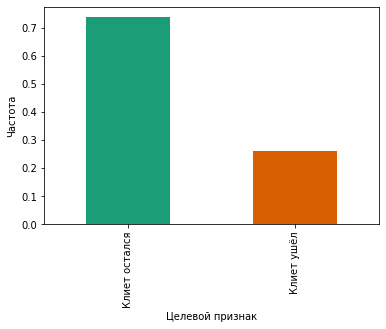

In [50]:
# проверим частоту 1 и 0 у целевого признака
class_frequency = data_train['number_rescind'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', color=plt.cm.Dark2(np.arange(len(personal_data))))
plt.ylabel('Частота')
plt.xlabel('Целевой признак')
plt.xticks([0,1],['Клиет остался', 'Клиет ушёл'])

В обучающей выборке наблюдается дисбланс классов, устраним его.

In [51]:
# обучающая выборка
features_train=data_train.drop(['number_rescind',], axis=1)
target_train=data_train['number_rescind']
# валидационная выборка
features_valid=data_valid.drop(['number_rescind'], axis=1)
target_valid=data_valid['number_rescind']
# тестовая выборка
features_test=data_test.drop(['number_rescind'], axis=1)
target_test=data_test['number_rescind']

In [52]:
from sklearn.utils import shuffle
# Техникой upsampling сделаем объекты редкого класса более частыми
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [53]:
features_upsampled, target_upsampled = upsample(features_train, target_train,3)


1    0.51663
0    0.48337
Name: number_rescind, dtype: float64


([<matplotlib.axis.XTick at 0x7f51012872d0>,
 <a list of 2 Text xticklabel objects>)

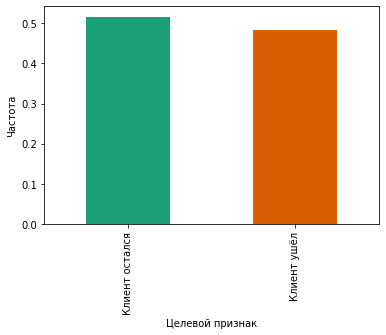

In [54]:
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', color=plt.cm.Dark2(np.arange(len(personal_data)))) 
plt.ylabel('Частота')
plt.xlabel('Целевой признак')
plt.xticks([0,1],['Клиент остался', 'Клиент ушёл'])

## 3.2 Обучение модели DecisionTreeClassifier

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

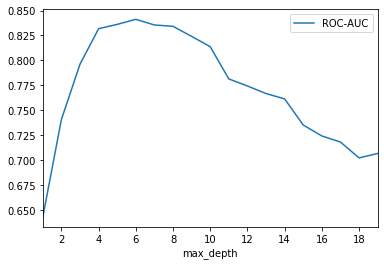

In [56]:
# подбор гиперпараметра depth
best_param = []
i=0
param=[]
for depth in range(1,20):
    model_tree =DecisionTreeClassifier(random_state=12345, max_depth= depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predict_valid=model_tree.predict(features_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_valid_tree = probabilities_valid_tree[:, 1]
    accuracy= accuracy_score(target_valid,predict_valid)
    ROC_AUC = roc_auc_score(target_valid, probabilities_valid_tree)
    param.append({'ROC-AUC':ROC_AUC, 'max_depth':depth })
    
    if ROC_AUC >i:
                best_param=[]
                best_param.append({'ROC-AUC':ROC_AUC})
                best_param.append({'accuracy':accuracy})
                best_param.append({'max_depth':depth})
                
                i=ROC_AUC

data=pd.DataFrame(param,columns =['max_depth', 'ROC-AUC'])     
data.plot(x='max_depth', y='ROC-AUC')

In [57]:
best_param

[{'ROC-AUC': 0.8411592906247912},
 {'accuracy': 0.7455579246624022},
 {'max_depth': 6}]

In [58]:
model_tree=DecisionTreeClassifier(random_state=12345, max_depth=6)

In [59]:
model_tree.fit(features_upsampled, target_upsampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [60]:
predict_valid_tree=model_tree.predict(features_valid)
Accuracy_tree_valid=print("Accuracy модели DecisionTree =", '{:.2f}'.format(accuracy_score(target_valid,predict_valid_tree)))
Accuracy_tree_valid=accuracy_score(target_valid,predict_valid_tree)

Accuracy модели DecisionTree = 0.75


In [61]:
probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_valid_tree = probabilities_valid_tree[:, 1]
AUC_ROC_tree_valid=print("AUC-ROC модели DecisionTree=",'{:.2f}'.format(roc_auc_score(target_valid, probabilities_valid_tree)))
AUC_ROC_tree_valid=roc_auc_score(target_valid, probabilities_valid_tree)

AUC-ROC модели DecisionTree= 0.84


## 3.3 Обучение модели RandomForestClassifier

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
# Подбираем гиперпараметр estimators и depth
best_param = []
i = 0
for estimators in range(10,200,40):
    for depth in range(3,12,3):
        model_forest =RandomForestClassifier(random_state=12345,  max_depth=depth, n_estimators=estimators)
        model_forest.fit(features_upsampled, target_upsampled)
        predict_valid=model_forest.predict(features_valid)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_valid_forest = probabilities_valid_forest[:, 1]
        ROC_AUC = roc_auc_score(target_valid, probabilities_valid_forest)
        accuracy = accuracy_score(target_valid,predict_valid)
        print("estimators =", estimators, ": ", end='')
        print("depth =", depth, ": ", end='')
        print("accuracy =",accuracy_score(target_valid,predict_valid))
        print("ROC-AUC =", roc_auc_score(target_valid, probabilities_valid_forest))
        if ROC_AUC >i:
                best_param=[]
                best_param.append({'ROC-AUC':ROC_AUC})
                best_param.append({'accuracy':accuracy})
                best_param.append({'max_depth':depth})
                best_param.append({'n_estimators':estimators})       
                i=ROC_AUC

estimators = 10 : depth = 3 : accuracy = 0.7341862117981521
ROC-AUC = 0.8414086723124625
estimators = 10 : depth = 6 : accuracy = 0.7491115849324804
ROC-AUC = 0.8528365238763683
estimators = 10 : depth = 9 : accuracy = 0.7668798862828714
ROC-AUC = 0.8542762532072542
estimators = 50 : depth = 3 : accuracy = 0.7164179104477612
ROC-AUC = 0.84925519716579
estimators = 50 : depth = 6 : accuracy = 0.744136460554371
ROC-AUC = 0.8569358960515424
estimators = 50 : depth = 9 : accuracy = 0.767590618336887
ROC-AUC = 0.8561183354672179
estimators = 90 : depth = 3 : accuracy = 0.7121535181236673
ROC-AUC = 0.8484646315064197
estimators = 90 : depth = 6 : accuracy = 0.744136460554371
ROC-AUC = 0.8574835073863257
estimators = 90 : depth = 9 : accuracy = 0.7661691542288557
ROC-AUC = 0.8572598351509917
estimators = 130 : depth = 3 : accuracy = 0.7100213219616205
ROC-AUC = 0.8479375877335061
estimators = 130 : depth = 6 : accuracy = 0.7455579246624022
ROC-AUC = 0.8580542572282124
estimators = 130 : depth

In [64]:
best_param

[{'ROC-AUC': 0.8587098482628123},
 {'accuracy': 0.7704335465529495},
 {'max_depth': 9},
 {'n_estimators': 170}]

In [65]:
model_forest=RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=170)

In [66]:
model_forest.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [67]:
predict_valid=model_forest.predict(features_valid)
Accuracy_forest_valid=print("Accuracy модели RandomForest =", '{:.2f}'.format(accuracy_score(target_valid,predict_valid)))  
Accuracy_forest_valid=accuracy_score(target_valid,predict_valid)

Accuracy модели RandomForest = 0.77


In [68]:
probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_valid_forest = probabilities_valid_forest[:, 1]
AUC_ROC_forest_valid=print("AUC-ROC модели RandomForest=",'{:.2f}'.format(roc_auc_score(target_valid, probabilities_valid_forest)))
AUC_ROC_forest_valid=roc_auc_score(target_valid, probabilities_valid_forest)

AUC-ROC модели RandomForest= 0.86


## 3.4 Обучение модели CatBoostClassifier

In [29]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

In [70]:
features = data_train.drop(['number_rescind'], axis=1)
target= data_train['number_rescind']

In [71]:
# функция кросс-валидации
def cross_valid(data, model):
    block_size=int(len(data)/3)
    j=0
    for depth in range(4,6):
        for estimators in range(600,1200,200):
            accuracy_par=[]
            roc_auc_par=[]
            model=model ### model.set_params(n_estimators=estimators, max_depth=depth)
            for i in range(0, len(data), block_size):
                        valid_indexes = data.iloc[i: i + block_size].index
                        train_indexes = (data.iloc[:i]+data.iloc[i+block_size:]).index

                        features_train=features.loc[train_indexes,:]
                        target_train=target.loc[train_indexes]
                        features_upsampled_2, target_upsampled_2 = upsample(features_train, target_train,3)

                        features_valid=features.loc[valid_indexes,:]
                        target_valid=target.loc[valid_indexes]


                        model = model.fit(features_upsampled_2, target_upsampled_2, verbose= False)

                        accuracy = accuracy_score(target_valid,model.predict(features_valid))
                        probabilities_valid = model.predict_proba(features_valid)
                        probabilities_valid = probabilities_valid[:, 1]
                        ROC_AUC = roc_auc_score(target_valid, probabilities_valid)

                        accuracy_par.append(accuracy)
                        roc_auc_par.append(ROC_AUC)

            accuracy_par=pd.Series(accuracy_par)
            final_accuracy=accuracy_par.mean()
            roc_auc_par=pd.Series(roc_auc_par)
            final_roc_auc=roc_auc_par.mean()
            
            if final_roc_auc >j:
                best_param=[]
                best_param.append({'ROC_AUC':final_roc_auc})
                best_param.append({'accuracy':final_accuracy})
                best_param.append({'depth':depth})
                best_param.append({'n_estimators': estimators})
                j=final_roc_auc
                

    return best_param 
    


In [72]:
cross_valid(data_train, CatBoostClassifier(learning_rate=0.03, n_estimators=estimators, max_depth=depth, random_state=2018))

[{'ROC_AUC': 0.8548611745319242},
 {'accuracy': 0.7783309625414888},
 {'depth': 4},
 {'n_estimators': 600}]

In [73]:
model_cat = CatBoostClassifier(depth=4, n_estimators=600, random_state=2018)

In [74]:
model_cat.fit(features_upsampled, target_upsampled, verbose=False)

In [75]:
predict_valid_cat=model_cat.predict(features_valid)

In [76]:
Accuracy_cat_valid=print("Accuracy модели CatBoost =", '{:.2f}'.format(accuracy_score(target_valid,predict_valid_cat))) 
Accuracy_cat_valid=accuracy_score(target_valid,predict_valid_cat)

Accuracy модели CatBoost = 0.80


In [77]:
probabilities_valid_cat = model_cat.predict_proba(features_valid)
probabilities_valid_cat = probabilities_valid_cat[:, 1]
AUC_ROC_cat_valid=print("AUC-ROC модели CatBoost=", '{:.2f}'.format(roc_auc_score(target_valid, probabilities_valid_cat)))
AUC_ROC_cat_valid=roc_auc_score(target_valid, probabilities_valid_cat)

AUC-ROC модели CatBoost= 0.89


# 3.5 Обучение модели LGBMClassifier

In [78]:
from lightgbm import LGBMClassifier

In [79]:
cross_valid(data_train, LGBMClassifier(learning_rate=0.03, n_estimators=estimators, max_depth=depth, random_state=2018))

[{'ROC_AUC': 0.8640654036336223},
 {'accuracy': 0.7745376955903271},
 {'depth': 4},
 {'n_estimators': 600}]

In [80]:
model_GBM = LGBMClassifier(learning_rate=0.03, depth=4, n_estimator=600, random_state=2018)

In [81]:
model_GBM.fit(features_upsampled, target_upsampled, verbose=False)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               depth=4, importance_type='split', learning_rate=0.03,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimator=600, n_estimators=100, n_jobs=-1,
               num_leaves=31, objective=None, random_state=2018, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [82]:
predict_valid_gbm=model_GBM.predict(features_valid)

In [83]:
Accuracy_GBM_valid=print("Accuracy модели LGBM =", '{:.2f}'.format(accuracy_score(target_valid,predict_valid_gbm))) 
Accuracy_GBM_valid=accuracy_score(target_valid,predict_valid_gbm)

Accuracy модели LGBM = 0.79


In [84]:
probabilities_valid_gbm = model_GBM.predict_proba(features_valid)
probabilities_valid_gbm = probabilities_valid_gbm[:, 1]
AUC_ROC_GBM_valid=print("AUC-ROC модели LGBM=", '{:.2f}'.format(roc_auc_score(target_valid, probabilities_valid_gbm)))
AUC_ROC_GBM_valid= roc_auc_score(target_valid, probabilities_valid_gbm)

AUC-ROC модели LGBM= 0.88


# 4. Тестирование модели

По результатам валидации наиболее точной моделью оказались CatBoostClassifier  с ROC-AUC=0.89. Проверим моделm на тестовых данных.

## 4.1 Тестирование CatBoostClassifier

In [85]:
predict_test_cat=model_cat.predict(features_test)

In [86]:
Accuracy_cat_test=print("Accuracy модели CatBoost =", '{:.2f}'.format(accuracy_score(target_test,predict_test_cat))) 
Accuracy_cat_test=accuracy_score(target_test,predict_test_cat)

Accuracy модели CatBoost = 0.79


In [87]:
probabilities_test_cat = model_cat.predict_proba(features_test)
probabilities_test_cat = probabilities_test_cat[:, 1]
AUC_ROC_cat_test=print("AUC-ROC модели CatBoost=", '{:.2f}'.format(roc_auc_score(target_test, probabilities_test_cat)))
AUC_ROC_cat_test=roc_auc_score(target_test, probabilities_test_cat)

AUC-ROC модели CatBoost= 0.88


## 4.2 Сводная таблица

In [88]:
data = {'Model':['DecisionTreeClassifier','RandomForestClassifier','CatBoost','LightGBMR'], 'ROC-AUC_valid':[AUC_ROC_tree_valid, AUC_ROC_forest_valid, AUC_ROC_cat_valid, AUC_ROC_GBM_valid],
        'Accuracy_valid':[Accuracy_tree_valid, Accuracy_forest_valid, Accuracy_cat_valid, Accuracy_GBM_valid], 'ROC-AUC_test':[0,0,AUC_ROC_cat_test,0],
       'Accuracy_test':[0,0,Accuracy_cat_test,0]}
df = pd.DataFrame(data).round(decimals=2).reset_index(drop=True)
df

,Model,ROC-AUC_valid,Accuracy_valid,ROC-AUC_test,Accuracy_test
0,DecisionTreeClassifier,0.84,0.75,0.00,0.00
1,RandomForestClassifier,0.86,0.77,0.00,0.00
2,CatBoost,0.89,0.80,0.88,0.79
3,LightGBMR,0.88,0.79,0.00,0.00


Лучшая модель CatBoostClassifier c ROC-AUC=0.89 и Accuracy=0.80

# Отчёт

1. Все пункты плана выполнены. Проведены предобработка и анализ данных, обучено несколько моделей и настроены гиперпараметры, для лучшей модели проведено тестирование. 
2. При настройке гиперпараметров для моделей градиентного бустинга было некорректно использовать стандартную кросс-валидацию на выборке, увеличенной с помощью upsampling. Так как применяя upsampling мы меняем исходное распределение данных,то при обычной кросс-валидации обучающая и валидационная выборки также будут иметь неправильное распределение. Для решения этой проблемы была написана собственная функцию для кросс-валидации, в которой только обучающая выборка каждый раз увеличивается с помощью upsampling.
3. Ключевые шаги,повлиявшие на качество моделей:
  1. Понимание того какие признаки важны, а какие можно исключить из обучения.
  2. Устранение дисбаланса классов в целевом признаке.
  3. Применение one-hot-кодирования. Так как алгоритмы машинного обучения, такие как RandomForest и DesicionTree из библиотеки        scikit-learn не рабатают с катерогиальными признаками, это было необходимо для них. Для моделей градиентного бустинга это        необязательно, но прямое кодирование не сильно "раздуло" матрицу признаков и в итоге только улучшило ключевые показатели        для этих моделей.
4. Итоговая модель: CatBoostClassifier c ROC-AUC=0.89 и Accuracy=0.80  
  